### Explore  h3 data calculations:

You can see more information in this [document](https://docs.google.com/document/d/1ciLKvZ_cfLWPEzo2buGikIDbM3auH0-L-pjcf-MkKeE/edit#heading=h.ftwkw9gb3uew)

The different resolutions would be:

<img src="../../datasets/raw/h3_levels.png" width="800" height="400"> 

## Table of Contents
- ### [Python libraries](#libraries)
- ### [1. Explore h3 levels](#h3_levels)
    - #### [1.1.Import geometries](#geometries)
    - #### [1.2. Test H3 resolution](#test_h3)
- ### [2. H3 Calculations](#crop_data)

<a id='libraries'></a>
## Python libraries

In [1]:
# install h3 lib
!pip install h3

In [155]:
import json
import time

import geopandas as gpd

# import libraries
import h3
import pandas as pd
import pandas_bokeh
from rasterstats import gen_zonal_stats
from shapely.geometry import Point, shape

pandas_bokeh.output_notebook()


import numpy as np
import scipy.special
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral10
from bokeh.plotting import figure, output_file, show

Loading BokehJS ...

<a id='h3_levels'></a>
## 1. Explore h3 levels

Based on the import data we will have two different set of resolutions:

    1. Deforestation dataser is 30m = 0.030km resolution and therefore, the carbon, biodiversity and deforestation metrics will have this  resolution - 
    2. Water indicator will have 12051.13116077543236m = 12.051km resolution
    
The H3 resolution that we choose should be slightly higher that the pixel resolution. Therefore:

    1. H3 Resolution 10 would be good for the deforestation, carbon and biodiversity dataset
    2. H3 Resolution 5 would be good for the water indicator dataset

In [31]:
# define function to covert geoms to h3


def generate_h3_features(geometry, res):
    """
    Generate h3 for geometry

    Input
    ------
    geometry: shapely.polygon or shapely.multipolygon

    Output
    ------
    gdf with H3_hexes
    """
    # Create an empty dataframe to write data into
    pd.DataFrame([], columns=["h3_id"])
    if geometry.geom_type == "MultiPolygon":
        district_polygon = list(geometry)
        for polygon in district_polygon:
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            poly_geojson = poly_geojson["features"][0]["geometry"]
            h3_hexes = h3.polyfill_geojson(poly_geojson, res)
            for h3_hex in h3_hexes:
                coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
                yield {
                    "type": "Feature",
                    "properties": {"hexid": h3_hex},
                    "geometry": {"type": "Polygon", "coordinates": coords[0]},
                }
    elif geometry.geom_type == "Polygon":
        poly_geojson = gpd.GeoSeries(geometry).__geo_interface__
        poly_geojson = poly_geojson["features"][0]["geometry"]
        h3_hexes = h3.polyfill_geojson(poly_geojson, res)
        for h3_hex in h3_hexes:
            coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
            yield {
                "type": "Feature",
                "properties": {"hexid": h3_hex},
                "geometry": {"type": "Polygon", "coordinates": coords[0]},
            }
    else:
        print("Shape is not a polygon or multypolygon.")


def get_h3_array(geom, raster_path, res, stats, prefix):
    """
    Function that trasnlate a raster into h3

    Input
    ------
    geom - geometry used for filling with h3
    raster_path - path to raster used for getting the information into the h3 features
    res - resolution of the h3 level
    stats - stats used in the summary stats
    prefix - for output in the summary stats column

    Output
    ------
    array - temporal array with hex id and stats info
    """
    h3_features = generate_h3_features(geom, res)

    summ_stats_h3_r5 = gen_zonal_stats(
        h3_features,
        raster_path,
        stats=stats,
        prefix=prefix,
        percent_cover_weighting=True,
        geojson_out=True,
        all_touched=True,
    )

    _array = []
    for feature in summ_stats_h3_r5:
        if feature["properties"][f"{prefix}{stats}"] != 0:
            element = {
                "sumStats": feature["properties"][f"{prefix}{stats}"],
                "hexId": feature["properties"]["hexid"],
            }
            _array.append(element)
    return _array


def make_plot(title, hist, edges, x, pdf, cdf):
    p = figure(title=title, tools="", background_fill_color="#fafafa")
    p.quad(
        top=hist,
        bottom=0,
        left=edges[:-1],
        right=edges[1:],
        fill_color="navy",
        line_color="white",
        alpha=0.5,
    )
    p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="PDF")
    p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend_label="CDF")

    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = "x"
    p.yaxis.axis_label = "Pr(x)"
    p.grid.grid_line_color = "white"
    return p

<a id='geometries'></a>
### 1.1. Import geometries:

In [3]:
# import indonesia clip test shape
gdf_ind = gpd.read_file("../../datasets/raw/input_data_test/indonesia_test_shape_clip.shp")
gdf_ind

,fid,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,1.0,Rubber,None,2600.0,Indonesia,None,None,None,Origin country,Low,"POLYGON ((11206146.856 334111.171, 11237288.10..."


In [4]:
# set geom to epsg 4326 for summ stats
gdf_ind = gdf_ind.to_crs("EPSG:4326")
gdf_ind.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

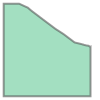

In [5]:
# get geometry to parse
geom = gdf_ind.iloc[0]["geometry"]
geom

In [6]:
# import world dataset
gdf_world = gpd.read_file("../../datasets/raw/input_data_test/world_shape_simpl.shp")
gdf_world

,FID,geometry
0,0,"MULTIPOLYGON (((-71.11750 -54.40319, -71.70583..."


In [7]:
# check crs of world geom
gdf_world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

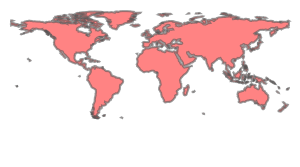

In [8]:
geom_world = gdf_world.iloc[0]["geometry"]
geom_world

<a id='test_h3'></a>
### 1.2. Test H3 resolution:

In [9]:
# rasters for testing calculations with different resolutions - need to be in epsg4326
raster_path_30m = "../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018_new_extent_4326.tif"
raster_path_10km = (
    "../../datasets/processed/processed_data/risk_map/water_risk_cotton_4326_2000_v2.tif"
)


raster_path_10km_3857 = (
    "../../datasets/processed/processed_data/risk_map/water_risk_cotton_3857_2000_v2.tif"
)

### Test resolution 5 - weighted median - 10km raster:

In [30]:
# get h3 array for resolution 5 and raster of 10km resolution
array_5_res = get_h3_array(geom, raster_path_10km, 5, "median", "wr_cotton_")

In [32]:
# export json
with open("./water_risk_res5.json", "w") as f:
    json.dump(array_5_res, f)

### Test resolution 6 - weighted median - 10km raster:

In [33]:
# get h3 array for resolution 5 and raster of 10km resolution
array_6_res = get_h3_array(geom, raster_path_10km, 6, "median", "wr_cotton_")

In [34]:
# export json
with open("./water_risk_res6.json", "w") as f:
    json.dump(array_6_res, f)

### Test resolution 6 - weighted mean - 10km raster:

In [10]:
# get h3 array for resolution 5 and raster of 10km resolution
array_6_res_mean = get_h3_array(geom, raster_path_10km, 6, "mean", "wr_cotton_")

In [11]:
# export json
with open("./water_risk_res6_mean.json", "w") as f:
    json.dump(array_6_res_mean, f)

### Test resolution 6 - weighted sum - 10km raster:

In [12]:
# get h3 array for resolution 5 and raster of 10km resolution
array_6_res_sum = get_h3_array(geom, raster_path_10km, 6, "sum", "wr_cotton_")

In [13]:
# export json
with open("./water_risk_res6_sum.json", "w") as f:
    json.dump(array_6_res_sum, f)

### Test resolution 6 - weighted sum - 30 m raster

In [35]:
# get h3 array for resolution 5 and raster of 10km resolution
array_6_res = get_h3_array(geom, raster_path_30m, 6, "sum", "wr_cotton_")

In [36]:
# export json
with open("./df_cotton_res6.json", "w") as f:
    json.dump(array_6_res, f)

### Test resolution 8- weighted sum - 30 m raster

In [37]:
# get h3 array for resolution 5 and raster of 10km resolution
array_8_res = get_h3_array(geom, raster_path_30m, 8, "sum", "wr_cotton_")

In [38]:
# export json
with open("./df_cotton_res8.json", "w") as f:
    json.dump(array_8_res, f)

### Test resolution 9 - weighted sum - 30 m raster

In [44]:
# get h3 array for resolution 5 and raster of 10km resolution
array_9_res = get_h3_array(geom, raster_path_30m, 9, "sum", "wr_cotton_")

In [45]:
# export json
with open("./df_cotton_res9.json", "w") as f:
    json.dump(array_9_res, f)

### Test resolution 9 - weighted mean - 30 m raster

In [47]:
# explore the res 9 but with weighted mean - difference with weighted sum
# get h3 array for resolution 5 and raster of 10km resolution
array_9_res = get_h3_array(geom, raster_path_30m, 9, "mean", "wr_cotton_")

In [48]:
# export json
with open("./df_cotton_res9_mean.json", "w") as f:
    json.dump(array_9_res, f)

### Test resolution 6 - weighted mean - 10km raster - global extent

In [15]:
# get h3 array for resolution 5 and raster of 10km resolution
array_6_res_world = get_h3_array(geom_world, raster_path_10km, 6, "mean", "wr_cotton_")

In [31]:
# export json
with open("./water_risk_cotton_res6_mean_global.json", "w") as f:
    json.dump(array_6_res_world_3857, f)

In [24]:
array_6_res_world_clean = [el for el in array_6_res_world if el["sumStats"] is not None]

In [26]:
with open("./water_risk_cotton_res6_mean_global_clean.json", "w") as f:
    json.dump(array_6_res_world_clean, f)

### Test resolution 1 - weighted sum - 10km raster - global extent

In [31]:
# get h3 array for resolution 5 and raster of 10km resolution
array_1_res_world = get_h3_array(geom_world, raster_path_10km, 1, "sum", "wr_cotton_")

In [32]:
# export json
with open("./water_risk_cotton_res1_mean_global.json", "w") as f:
    json.dump(array_1_res_world, f)

### Test resolution 3 - weighted sum - 10km raster - global extent

In [33]:
# get h3 array for resolution 5 and raster of 10km resolution
array_3_res_world = get_h3_array(geom_world, raster_path_10km, 3, "sum", "wr_cotton_")

In [34]:
# export json
with open("./water_risk_cotton_res3_mean_global.json", "w") as f:
    json.dump(array_3_res_world, f)

### Test resolution 5 - weighted sum - 10km raster - global extent

In [35]:
# get h3 array for resolution 5 and raster of 10km resolution
array_5_res_world = get_h3_array(geom_world, raster_path_10km, 5, "sum", "wr_cotton_")

In [17]:
# export json
with open("./water_risk_cotton_res5_sum_global.json", "w") as f:
    json.dump(array_5_res_world, f)

In [80]:
# clean none from res 5

with open("./water_risk_cotton_res5_mean_global.json", "r") as f:
    array_5_res_world = json.load(f)

In [15]:
array_5_res_world = [el for el in array_5_res_world if el["sumStats"] is not None]

### Test resolution 6 - weighted sum - 10km raster - global extent

In [37]:
# get h3 array for resolution 5 and raster of 10km resolution
array_6_res_world = get_h3_array(geom_world, raster_path_10km, 6, "sum", "wr_cotton_")

In [11]:
# export json
with open("./water_risk_cotton_res6_sum_global.json", "w") as f:
    json.dump(array_6_res_world, f)

In [4]:
with open("./water_risk_cotton_res6_sum_global.json", "r") as f:
    array_6_res_world = json.load(f)

In [9]:
array_6_res_world = [el for el in array_6_res_world if el["sumStats"] is not None]

### Test reprojection to EPSG3857 - GLOBAL EXTENT

In [6]:
generator = generate_h3_features(geom_world, 6)

In [7]:
_array = []
for feature in generator:
    element = {"hexId": feature["properties"]["hexid"], "geometry": feature["geometry"]}
    _array.append(element)

In [9]:
gdf = gpd.GeoDataFrame(_array)
gdf.head()

,hexId,geometry
0,86df6c38fffffff,"{'type': 'Polygon', 'coordinates': [[(-71.3949..."
1,86df6c72fffffff,"{'type': 'Polygon', 'coordinates': [[(-71.1318..."
2,86df6c047ffffff,"{'type': 'Polygon', 'coordinates': [[(-71.5087..."
3,86df6c3b7ffffff,"{'type': 'Polygon', 'coordinates': [[(-71.3732..."
4,86df6c707ffffff,"{'type': 'Polygon', 'coordinates': [[(-71.1318..."


In [25]:
geometries = []
for i, row in gdf.iterrows():
    geom = shape(row["geometry"])
    geometries.append(geom)
gdf["geometry"] = geometries

In [27]:
gdf = gdf.set_geometry("geometry")
gdf.crs

In [29]:
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")
gdf.head()

,hexId,geometry
0,86df6c38fffffff,"POLYGON ((-7947646.733 -7183618.340, -7941963...."
1,86df6c72fffffff,"POLYGON ((-7918358.386 -7221977.474, -7920405...."
2,86df6c047ffffff,"POLYGON ((-7960318.979 -7209354.494, -7962339...."
3,86df6c3b7ffffff,"POLYGON ((-7945235.413 -7206327.750, -7941568...."
4,86df6c707ffffff,"POLYGON ((-7918358.386 -7221977.474, -7922013...."


In [31]:
gdf.to_file("./world_geom_3857.json", driver="GeoJSON")

### Try to get the geoms from the already generated file:

In [12]:
with open("./water_risk_cotton_res6_mean_global_clean.json", "r") as f:
    array_6_res_world_clean = json.load(f)

In [14]:
gdf = gpd.GeoDataFrame(array_6_res_world_clean)
gdf.head()

,sumStats,hexId
0,0.406926,864010a77ffffff
1,0.449853,866a588a7ffffff
2,0.463098,86752341fffffff
3,3.238817,864032137ffffff
4,0.198091,862150517ffffff


In [26]:
geometries = []
for i, row in gdf.iterrows():
    hexid = row["hexId"]
    coords = h3.h3_set_to_multi_polygon([hexid], geo_json=True)
    geom_feature = {"type": "Polygon", "coordinates": coords[0]}
    geom = shape(geom_feature)
    geometries.append(geom)

In [27]:
# append geometry in epsg4326
gdf["geometry"] = geometries
gdf.head()

,sumStats,hexId,geometry
0,0.406926,864010a77ffffff,"POLYGON ((110.65986 28.55930, 110.68977 28.537..."
1,0.449853,866a588a7ffffff,"POLYGON ((34.23232 4.65150, 34.25434 4.62513, ..."
2,0.463098,86752341fffffff,"POLYGON ((-2.42951 8.59922, -2.40199 8.60573, ..."
3,3.238817,864032137ffffff,"POLYGON ((112.83420 27.14084, 112.80058 27.130..."
4,0.198091,862150517ffffff,"POLYGON ((69.85305 51.02079, 69.79852 51.03369..."


In [28]:
gdf = gdf.set_geometry("geometry")
gdf.crs

In [29]:
# set crs to epsg4326 and reproject to epsg3857
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
# save as json
gdf.to_file("./water_risk_cotton_res6_mean_global_clean_3857.json", driver="GeoJSON")

### Generate centroids layer -res 6 - global extent


In [19]:
with open("./water_risk_cotton_res6_mean_global_clean.json", "r") as f:
    array_6_res_world_clean = json.load(f)

In [20]:
gdf = gpd.GeoDataFrame(array_6_res_world_clean)
gdf.head()

,sumStats,hexId
0,0.406926,864010a77ffffff
1,0.449853,866a588a7ffffff
2,0.463098,86752341fffffff
3,3.238817,864032137ffffff
4,0.198091,862150517ffffff


In [32]:
geometries = []
for i, row in gdf.iterrows():
    hexid = row["hexId"]
    centroid = h3.h3_to_geo(hexid)
    point = Point(centroid[1], centroid[0])
    geometries.append(point)

In [33]:
gdf["geometry"] = geometries
gdf.head()

,sumStats,hexId,geometry
0,0.406926,864010a77ffffff,POINT (110.69422 28.56953)
1,0.449853,866a588a7ffffff,POINT (34.26676 4.65582)
2,0.463098,86752341fffffff,POINT (-2.42511 8.62751)
3,3.238817,864032137ffffff,POINT (112.82961 27.10906)
4,0.198091,862150517ffffff,POINT (69.80788 50.99762)


In [34]:
gdf = gdf.set_geometry("geometry")
gdf = gdf.set_crs("EPSG:4326")

In [35]:
gdf.to_file("./water_risk_cotton_res6_mean_global_clean_point.json", driver="GeoJSON")

<a id='crop_data'></a>
## 2. H3 Calculations

As part of the workflow we will have:

1. Generation of script for generating the risk maps for each indicators - ones those risk maos are generated, we will need to translate them into h3 using the approach highlighted above
2. get the admin areas into h3 indexes in the database using the pg plugging for translating geometries into h3 indexes
3. Perform calculations for each area by aggregating step 1 and 2

### 2.1 Get user data into h3 res 6:


In [3]:
## import user data
user_data = gpd.read_file("../../datasets/processed/user_data/located_lg_data_polygon_v2.shp")
user_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39..."
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6..."
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000..."
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ..."
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [5]:
user_data[user_data["Material"] == "Cotton"].iloc[0]

Material                                                 Cotton
Material d                                                 None
Volume                                                     4000
Country                                                   China
Address                                                    None
Latitude                                                   None
Longitude                                                  None
Location t                                              Unknown
Accuracy                                                    Low
geometry      (POLYGON ((73.4997347 39.3817402, 73.5046849 3...
Name: 14, dtype: object

In [4]:
# check with one location
geom = user_data[user_data["Material"] == "Cotton"].iloc[0]["geometry"]
generator = generate_h3_features(geom, 6)

In [5]:
test_china = [
    {"volume": 2400, "hexid": feature["properties"]["hexid"], "geometry": feature["geometry"]}
    for feature in generator
]

### 2.2. Caclulate the probability area distribution:

We can calculate the probability area distribution using the following formula:

    f' = (V * Af) / (AT * Yield)
    
to do this we will need the folloing datasets:

- volume raster derived from user data
- area fraction for a particular commodity
- the total area fraction for the user location
- yield information for a particular commodity

In [8]:
harvest_area_fraction_raster = {
    "Rubber": "../../datasets/raw/crop_data/rubber/rubber_HarvestedAreaFraction.tif",
    "Cotton": "../../datasets/raw/crop_data/cotton/cotton_HarvestedAreaFraction.tif",
    "Leather": "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/asture2000_5m_ext_v2.tif",
}

yield_raster = {
    "Rubber": "../../datasets/raw/crop_data/rubber/rubber_YieldPerHectare.tif",
    "Cotton": "../../datasets/raw/crop_data/cotton/cotton_YieldPerHectare.tif",
    "Leather": "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros.tif",
}

In [9]:
# zonal stats for harvest area
start_time = time.time()
material = user_data.iloc[0]["Material"]
raster_path_ha = harvest_area_fraction_raster[material]
_array_ha = get_h3_array(geom, raster_path_ha, 6, "mean", "ha")
print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


--- 799.8059668540955 seconds ---


In [19]:
# parse harvest area fraction to h3 index
for el in test_china:
    harvest_area_list = [ha["sumStats"] for ha in _array_ha if ha["hexId"] == el["hexid"]]
    harvest_area = harvest_area_list[0] if len(harvest_area_list) > 0 else 0
    el["ha"] = harvest_area

In [21]:
# export unique user data
with open(
    "../../datasets/processed/user_data/located_lg_data_polygon_v2_h3_unique_china_ha.json", "w"
) as f:
    json.dump(test_china, f)

In [15]:
with open(
    "../../datasets/processed/user_data/located_lg_data_polygon_v2_h3_unique_china_ha.json", "r"
) as f:
    test_china = json.load(f)

In [19]:
# get sum of haf to calculate probability area distribution

total_ha = sum([el["ha"] for el in test_china])

# calculate probability area

for el in test_china:
    p_dis = float((el["ha"] * el["volume"]) / total_ha)
    el["p_dis"] = p_dis

In [21]:
# remove 0
test_china = [el for el in test_china if el["p_dis"] != 0]

In [23]:
# export unique user data
with open(
    "../../datasets/processed/user_data/located_lg_data_polygon_v2_h3_unique_china_ha_pdis.json",
    "w",
) as f:
    json.dump(test_china, f)

In [40]:
# export unique user data
with open(
    "../../datasets/processed/user_data/located_lg_data_polygon_v2_h3_unique_china_ha_pdis.json",
    "r",
) as f:
    test_china = json.load(f)

### 2.3 Calculate impact metric:

In [39]:
# risk map in h3 - water risk cotton
cotton_water_risk = pd.read_json(
    "../../datasets/processed/water_indicators/water_risk_cotton_res6_mean_global_clean.json"
)
cotton_water_risk.head()

,sumStats,hexId
0,0.406926,864010a77ffffff
1,0.449853,866a588a7ffffff
2,0.463098,86752341fffffff
3,3.238817,864032137ffffff
4,0.198091,862150517ffffff


In [41]:
## user probability area distribution - calculate before for china

user_data_china = pd.DataFrame(test_china)
user_data_china.head()

,volume,hexid,geometry,ha,p_dis
0,2400,863c2aaefffffff,"{'type': 'Polygon', 'coordinates': [[[87.89723...",0.000003,0.000050
1,2400,863c48537ffffff,"{'type': 'Polygon', 'coordinates': [[[97.44161...",0.000019,0.000320
2,2400,863c59377ffffff,"{'type': 'Polygon', 'coordinates': [[[97.72652...",0.000015,0.000252
3,2400,8640f24afffffff,"{'type': 'Polygon', 'coordinates': [[[107.1846...",0.000771,0.013024
4,2400,86408602fffffff,"{'type': 'Polygon', 'coordinates': [[[112.8473...",0.000885,0.014937


In [42]:
# calculation of metric
merge_df = pd.merge(
    user_data_china, cotton_water_risk, how="inner", left_on="hexid", right_on="hexId"
)
merge_df.head()

,volume,hexid,geometry,ha,p_dis,sumStats,hexId
0,2400,8640f24afffffff,"{'type': 'Polygon', 'coordinates': [[[107.1846...",0.000771,0.013024,0.693534,8640f24afffffff
1,2400,86408602fffffff,"{'type': 'Polygon', 'coordinates': [[[112.8473...",0.000885,0.014937,19.138670,86408602fffffff
2,2400,86208b28fffffff,"{'type': 'Polygon', 'coordinates': [[[76.67422...",0.000196,0.003304,0.244726,86208b28fffffff
3,2400,864b36b5fffffff,"{'type': 'Polygon', 'coordinates': [[[121.0798...",0.000237,0.004004,0.224951,864b36b5fffffff
4,2400,8620d2247ffffff,"{'type': 'Polygon', 'coordinates': [[[79.40063...",0.000060,0.001021,0.939304,8620d2247ffffff


In [36]:
# save as json
china_impact = []
for i, row in merge_df.iterrows():
    element = {
        "volume": row["volume"],
        "hexid": row["hexid"],
        "geometry": row["geometry"],
        "impact": float(row["p_dis"] * row["sumStats"]),
    }
    china_impact.append(element)

In [43]:
with open("../../datasets/processed/water_indicators/water impact_china_h3.json", "w") as f:
    json.dump(china_impact, f)

In [7]:
with open("../../datasets/processed/water_indicators/water impact_china_h3.json", "r") as f:
    china_test = json.load(f)

In [10]:
gdf = gpd.GeoDataFrame(china_test)
gdf.head()

,volume,hexid,geometry,impact
0,2400,8640f24afffffff,"{'type': 'Polygon', 'coordinates': [[[107.1846...",0.009032
1,2400,86408602fffffff,"{'type': 'Polygon', 'coordinates': [[[112.8473...",0.285882
2,2400,86208b28fffffff,"{'type': 'Polygon', 'coordinates': [[[76.67422...",0.000809
3,2400,864b36b5fffffff,"{'type': 'Polygon', 'coordinates': [[[121.0798...",0.000901
4,2400,8620d2247ffffff,"{'type': 'Polygon', 'coordinates': [[[79.40063...",0.000959


In [19]:
gdf["geometry"] = [shape(row["geometry"]) for i, row in gdf.iterrows()]
gdf.head()

,volume,hexid,geometry,impact
0,2400,8640f24afffffff,"POLYGON ((107.18462 33.27653, 107.18040 33.246...",0.009032
1,2400,86408602fffffff,"POLYGON ((112.84735 33.43795, 112.84264 33.408...",0.285882
2,2400,86208b28fffffff,"POLYGON ((76.67422 37.40554, 76.71535 37.39027...",0.000809
3,2400,864b36b5fffffff,"POLYGON ((121.07985 29.22806, 121.11258 29.242...",0.000901
4,2400,8620d2247ffffff,"POLYGON ((79.40064 37.42992, 79.36041 37.44607...",0.000959


In [20]:
gdf.to_file("./china_test.shp", driver="ESRI Shapefile")

In [29]:
# Normal Distribution

mu, sigma = 0, 0.5

measured = np.random.normal(mu, sigma, 1000)
hist, edges = np.histogram(gdf["impact"], density=True, bins=50)

x = np.linspace(-2, 2, 1000)
pdf = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
cdf = (1 + scipy.special.erf((x - mu) / np.sqrt(2 * sigma**2))) / 2

p1 = make_plot("Normal Distribution (μ=0, σ=0.5)", hist, edges, x, pdf, cdf)

# Log-Normal Distribution

mu, sigma = 0, 0.5

measured = np.random.lognormal(mu, sigma, 1000)
hist, edges = np.histogram(gdf["impact"], density=True, bins=50)

x = np.linspace(0.0001, 8.0, 1000)
pdf = 1 / (x * sigma * np.sqrt(2 * np.pi)) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma**2))
cdf = (1 + scipy.special.erf((np.log(x) - mu) / (np.sqrt(2) * sigma))) / 2

p2 = make_plot("Log Normal Distribution (μ=0, σ=0.5)", hist, edges, x, pdf, cdf)

# Gamma Distribution

k, theta = 7.5, 1.0

measured = np.random.gamma(k, theta, 1000)
hist, edges = np.histogram(gdf["impact"], density=True, bins=50)

x = np.linspace(0.0001, 20.0, 1000)
pdf = x ** (k - 1) * np.exp(-x / theta) / (theta**k * scipy.special.gamma(k))
cdf = scipy.special.gammainc(k, x / theta)

p3 = make_plot("Gamma Distribution (k=7.5, θ=1)", hist, edges, x, pdf, cdf)

# Weibull Distribution

lam, k = 1, 1.25
measured = lam * (-np.log(np.random.uniform(0, 1, 1000))) ** (1 / k)
hist, edges = np.histogram(gdf["impact"], density=True, bins=50)

x = np.linspace(0.0001, 8, 1000)
pdf = (k / lam) * (x / lam) ** (k - 1) * np.exp(-((x / lam) ** k))
cdf = 1 - np.exp(-((x / lam) ** k))

p4 = make_plot("Weibull Distribution (λ=1, k=1.25)", hist, edges, x, pdf, cdf)

output_file("histogram.html", title="histogram.py example")

show(gridplot([p1, p2, p3, p4], ncols=2, plot_width=400, plot_height=400, toolbar_location=None))

In [38]:
# using this h3 methodology - the total impact would be the sum of the distributed impacts
print(
    f"The unsustainable water use impact for buying 2400 tonnes of cotton in China would be {sum(gdf['impact'])} m3 / year"
)

The unsustainable water use impact for buying 2400 tonnes of cotton in China would be 100532.66914021136 m3 / year


In [50]:
# download projection over time -

ha_00_19 = pd.read_csv("../../datasets/raw/crop_data/FAOSTAT_ha_2000_2019.csv")
ha_00_19.head()

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2000,2000,ha,50000.0,*,Unofficial figure
1,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2001,2001,ha,50000.0,*,Unofficial figure
2,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2002,2002,ha,50000.0,*,Unofficial figure
3,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2003,2003,ha,30000.0,NaN,Official data
4,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2004,2004,ha,25500.0,NaN,Official data


In [61]:
ha_00_19[(ha_00_19["Year"] == 2000) & (ha_00_19["Area"] == "Afghanistan")]["Value"][0]

50000.0

In [94]:
unique_years = ha_00_19.Year.unique()
unique_countries = ha_00_19.Area.unique()

ha_byYear = []
for country in unique_countries:
    element = {"country": country}
    for year in unique_years:
        try:
            value = float(
                list(ha_00_19[(ha_00_19["Area"] == country) & (ha_00_19["Year"] == year)]["Value"])[
                    0
                ]
            )
        except:
            value = 0

        element[f"{year}"] = value
    ha_byYear.append(element)

In [95]:
ha_df = pd.DataFrame(ha_byYear)
ha_df.head()

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,50000.0,50000.0,50000.0,30000.0,25500.0,30000.0,31950.0,35000.0,35000.0,...,33000.0,33000.0,33000.0,36300.0,35000.0,42124.0,51102.0,31845.0,39496.0,49371.0
1,Albania,990.0,840.0,840.0,1000.0,1060.0,1080.0,1080.0,950.0,740.0,...,740.0,740.0,740.0,740.0,740.0,740.0,740.0,740.0,740.0,617.0
2,Algeria,141.0,143.0,146.0,151.0,155.0,82.0,106.0,124.0,143.0,...,200.0,211.0,250.0,260.0,260.0,260.0,260.0,260.0,260.0,275.0
3,Angola,10000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,...,2000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,2945.0
4,Antigua and Barbuda,600.0,600.0,650.0,700.0,700.0,700.0,700.0,700.0,700.0,...,700.0,700.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,599.0


In [109]:
pct_change_df = ha_df[
    [
        "2000",
        "2001",
        "2002",
        "2003",
        "2004",
        "2005",
        "2006",
        "2007",
        "2008",
        "2009",
        "2010",
        "2011",
        "2012",
        "2013",
        "2014",
        "2015",
        "2016",
        "2017",
        "2018",
        "2019",
    ]
].pct_change(axis=1)

# add countries
pct_change_df["country"] = ha_df["country"]
pct_change_df.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,country
0,NaN,0.000000,0.000000,-0.400000,-0.15000,0.176471,0.065000,0.095462,0.000000,-0.057143,...,0.000,0.000000,0.10,-0.035813,0.203543,0.213133,-0.376835,0.240257,0.250025,Afghanistan
1,NaN,-0.151515,0.000000,0.190476,0.06000,0.018868,0.000000,-0.120370,-0.221053,0.000000,...,0.000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.166216,Albania
2,NaN,0.014184,0.020979,0.034247,0.02649,-0.470968,0.292683,0.169811,0.153226,0.139860,...,0.055,0.184834,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.057692,Algeria
3,NaN,-0.800000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018333,Angola
4,NaN,0.000000,0.083333,0.076923,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,-0.142857,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001667,Antigua and Barbuda


In [165]:
pct_change_df.to_csv("../../datasets/raw/crop_data/projection_factor_byCountry.csv")

In [120]:
# filter by china mainland
pct_change_china = pct_change_df[pct_change_df["country"] == "China, mainland"]
pct_change_china["2000"] = 0
pct_change_china

<ipython-input-120-6d3cd98700ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pct_change_china['2000']=0


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,country
21,0,0.190235,-0.130057,0.2215,0.113872,-0.110855,0.148916,0.018983,-0.029024,-0.139426,...,0.038936,-0.069409,-0.073057,-0.02838,-0.107863,-0.103739,0.435088,-0.307655,0.435534,"China, mainland"


In [117]:
pct_change_china["2001"].iloc[0]

0.19023509032417718

In [139]:
# to json
pct_change_china_json = {}
for el in pct_change_china.columns:
    if el != "country":
        pct_change_china_json[el] = pct_change_china[el].iloc[0]

# total_volume is 2400
total_vol = 2400
# value is going to be (2000val + (factor*2000val))
# project average
average_risk = sum(merge_df["sumStats"]) / len(merge_df["sumStats"])
pr_average_imp = [
    (average_risk + pct_change_china_json[f"{year}"] * average_risk) * total_vol
    for year in range(2000, 2020)
]

# project min
min_risk = min(merge_df["sumStats"])
pr_min_imp = [
    (min_risk + pct_change_china_json[f"{year}"] * min_risk) * total_vol
    for year in range(2000, 2020)
]

# project max
max_risk = max(merge_df["sumStats"])
pr_max_imp = [
    (max_risk + pct_change_china_json[f"{year}"] * max_risk) * total_vol
    for year in range(2000, 2020)
]


# project sum
total_impact = sum(gdf["impact"])
pr_total_imp = [
    (total_impact + pct_change_china_json[f"{year}"] * total_impact) for year in range(2000, 2020)
]


# generate dataframe
df = pd.DataFrame()
df["year"] = [year for year in range(2000, 2020)]
df["average_imp"] = pr_average_imp
df["min_imp"] = pr_min_imp
df["max_imp"] = pr_max_imp
df["total_imp"] = pr_total_imp
df.head()

,year,average_imp,min_imp,max_imp,total_imp
0,2000,74522.894697,7.722101e-11,2.588871e+06,100532.669140
1,2001,88699.764301,9.191116e-11,3.081366e+06,119657.510535
2,2002,64830.676085,6.717788e-11,2.252171e+06,87457.699214
3,2003,91029.710530,9.432546e-11,3.162306e+06,122800.648147
4,2004,83008.968795,8.601432e-11,2.883671e+06,111980.529332


In [164]:
df["year"] = pd.to_datetime(df["year"], format="%Y")

source = ColumnDataSource(df)

p = figure(x_axis_type="datetime")

p.line(x="year", y="average_imp", line_width=2, source=source, legend="Average impact")
p.line(x="year", y="min_imp", line_width=2, source=source, color=Spectral10[5], legend="Min impact")
p.line(x="year", y="max_imp", line_width=2, source=source, color=Spectral10[9], legend="Max impact")
p.line(
    x="year",
    y="total_imp",
    line_width=2,
    source=source,
    color=Spectral10[6],
    legend="Total impacts",
)

p.title.text = "Unsustainable water use impacts for Cotton in China"
p.yaxis.axis_label = "m3 / year"
show(p)

## 3. Final Notes

- for the translation into h3:

    - for the resolution of 10km, the resolution of 6 for the H3 looks better than the resolution of 5
    - Raster with 10km resolution will be translated to H3 using the Res 6 and the weighted mean
    - Ratsers with 30m resolution will be translated to H3 using the Res 10 and the weighted mean
    - Alternatively this 30m rasters will be translated to the Res 9 using the weighted sum
    - The aggregation to different zoom levels would be done using the weighted sum


- for the caculation:
    
    - translate the intersection to sql
    
    